# **KSP 5.0 Selection Assignment**





In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import math
from scipy.stats import norm

# Section 1: Calculating the Redshift of Galaxies

You are given the data for all the galaxies in the cluster in the file 'galaxy.csv'.

This includes the name of the galaxy, observed wavelength of the $H\alpha$ line $\lambda_{H\alpha}$, Right Ascension at J2000.0 and Declination at J2000.0 (You can read more about RA and Dec [here](https://en.wikipedia.org/wiki/Equatorial_coordinate_system))

In [28]:
galaxy_data = pd.read_csv('data/galaxy.csv')


Since the galaxies would have some radial velocities with respect to us, the wavelengths we observed would be [redshifted](https://en.wikipedia.org/wiki/Redshift) due to doppler effect.

Using the value of the Observed Wavelength of $H\alpha$ line (Rest Wavelength $\lambda_{H\alpha0} = 6562.8nm)$, calculate the redshift of the galaxies in our cluster.

Use this to find their radial velocities of the galaxies and plot it.

(Assume that the observed wavelength has been correscted for the motion of earth around sun, and motion of sun around the center of Milky Way. Put more simply, these are the wavelengths you would have observed if you were at rest at the center of Milky Way)

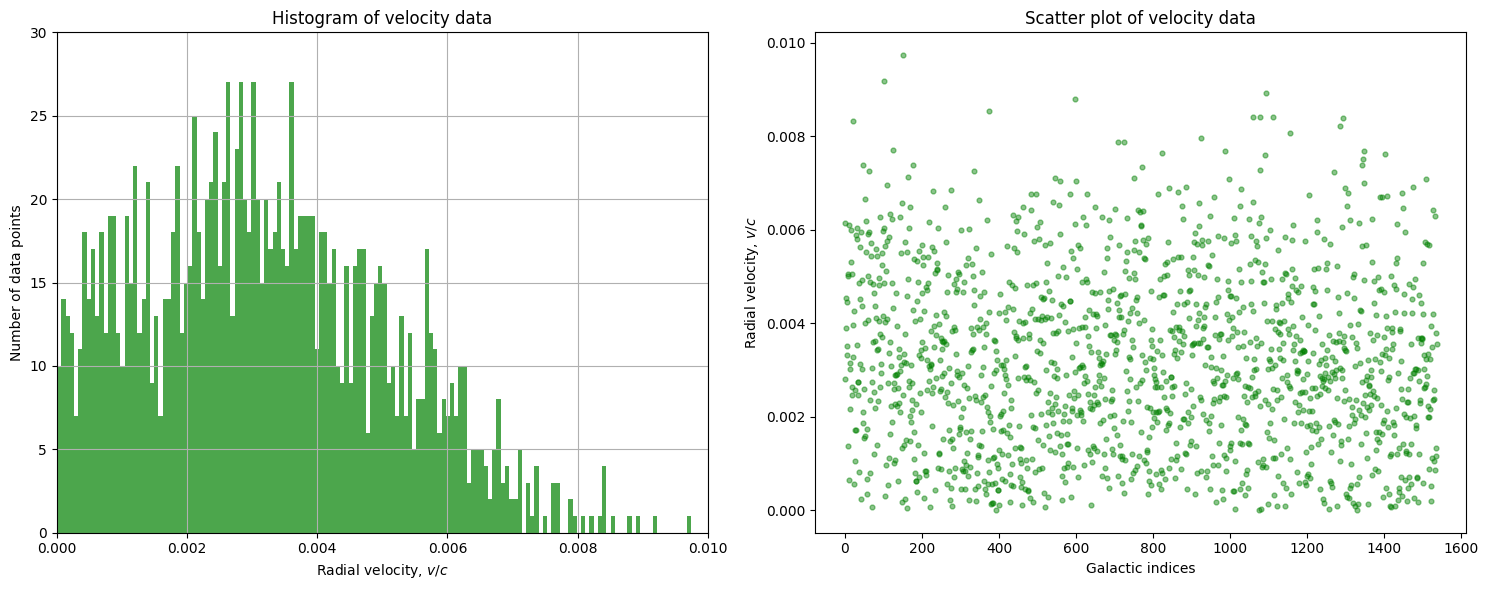

In [29]:
lambda_obs = galaxy_data['Observed Wavelength of H-alpha'].values
lambda_emit = 6562.80  # in nm
c = 3e8
z_params = np.zeros(len(lambda_obs))
radial_vel = np.zeros(len(lambda_obs))

for i in range(len(lambda_obs)):
  z_params[i] = abs((lambda_obs[i]/lambda_emit)-1)
  radial_vel[i] = ((1+z_params[i])**2-1)/((1+z_params[i]**2+1))  # z approx equal to v/c for v << c

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Histogram plotting
ax1.hist(radial_vel, bins=150, density=False, alpha=0.7, color='g')
ax1.set_xlabel('Radial velocity, 'r'$v/c$')
ax1.set_ylabel('Number of data points')
ax1.set_title('Histogram of velocity data')
ax1.set_ylim(0,30)
ax1.set_xlim(0,0.01)
ax1.grid(True)

#Scatter plot
indices = np.arange(len(z_params))
ax2.scatter(indices, radial_vel, s=12, c='g', alpha=0.45)
ax2.set_xlabel('Galactic indices')
ax2.set_ylabel('Radial velocity, 'r'$v/c$')
ax2.set_title('Scatter plot of velocity data')

plt.tight_layout()
plt.show()

Using the data from galaxy.csv, answer the following questions.

For your convenience, the RA and Dec data has been converted from the format $a^\circ b^m c^s$ to $xx^\circ$ below


In [30]:
temp = galaxy_data['RA J2000.0'].str.split(' ', expand=True)
galaxy_data['RA J2000.0'] = temp[0].astype(float) + temp[1].astype(float) / 60 + temp[2].astype(float) / 3600
temp = galaxy_data['Dec J2000.0'].str.split(' ', expand=True)
galaxy_data['Dec J2000.0'] = temp[0].astype(float) + temp[1].astype(float) / 60 + temp[2].astype(float) / 3600

***

###Q1.1. What is the approximate angular size of the galaxy cluster?

\<$\Delta \text{RA}_{max} \times \Delta \text{Dec}_{max} = 1.80708^{\circ} \times 31.49583^{\circ}$\>

***

###Q1.2. Can you comment anything about the rotation of the galaxies around the center of the cluster.
HINT: You may find it useful to plot a scatter plot of RA and DEC with radial velocity as colormap.

\<As the Declination (DA) of the galaxies increases, their radial velocity increases too. Interestingly, the parameter of Right Ascension (RA) does not seem to affect the rotation of the galaxies around the center, as can be inferred from the uniformity of the radial velocity wrt RA.\>   

***

In [31]:
RA_vals = galaxy_data['RA J2000.0'].values
Dec_vals = galaxy_data['Dec J2000.0'].values

def max_diff(lst):
    min_val = lst[0]
    max_diff = 0

    for num in lst:
        min_val = min(min_val, num)
        max_diff = max(max_diff, num - min_val)
    return max_diff

print("Maximum RA J2000.0 angular difference:", round(max_diff(RA_vals),5)) # in degrees
print("Maximum Dec J2000.0 angular difference:", round(max_diff(Dec_vals),5))

Maximum RA J2000.0 angular difference: 1.80708
Maximum Dec J2000.0 angular difference: 31.49583


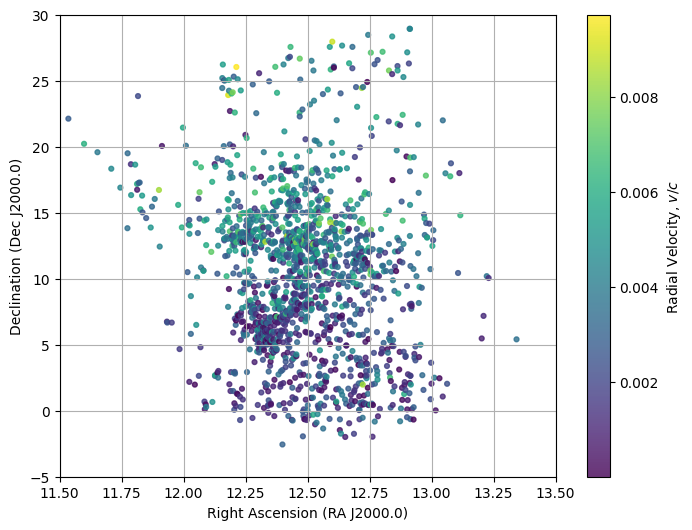

In [32]:
plt.figure(figsize=(8,6))
scatter = plt.scatter(RA_vals, Dec_vals, c=radial_vel, s=12, cmap='viridis', alpha=0.8)
plt.colorbar(scatter, label='Radial Velocity, 'r'$v/c$')

plt.xlabel('Right Ascension (RA J2000.0)')
plt.ylabel('Declination (Dec J2000.0)')
plt.xlim(11.5,13.5)
plt.ylim(-5,30)

plt.grid(True)
plt.show()

#Section 2: Calibrating Cepheids Data

NOTE: Although there are no prerequisities for this section, it relies a bit on knowledge about cepheids and their Period-Luminosity Relation. Necessary resource links have been provided wherever needed. You are strongly encouraged to use the internet to aid as a reference whenever needed.
***

The [Gaia Mission](https://en.wikipedia.org/wiki/Gaia_(spacecraft) aims at cataloging and create a precise three-dimensional map of astronomical objects throughout the Mily Way. It maps the motion of the stars, which encode the origin and subsequent evolution of the Milky Way. The spectrophotometric measurements provide detailed physical properties of all stars observed, characterizing their luminosity, effective temperature, gravity and elemental composition.





In [33]:
gaia_data = pd.read_csv('data/gaia.csv')

Cepheids are a particular type of variable stars that pulsate radially, varying in both diameter and temperature. They **change in brightness**, with a **well-defined stable period and amplitude**.

The file 'gaia.csv' includes data for about 5000 Cepheid Variable Stars in our own galaxy. In particular, the file contains the following data fields:
   
*   Unique ID of the Source Star
*   Parallax (in milli arcseconds) : You can read more about parallax [here](https://en.wikipedia.org/wiki/Stellar_parallax)
*   Mean **Apparent** Magnitude ($m$)
*   TIme period of Pulsations P (in days)



Classical Cepheids follow the [Period Luminosity Law](https://en.wikipedia.org/wiki/Period-luminosity_relation#The_relations), also commonly known as the Leavitt Law.

It basically states that there is an empirical relation between the pulsation period $(P)$ of a Cepheid Star and it's **Absolute Magnitude** ($M$) of the form -

#### $\begin{equation}M = \alpha \log_{10}(P \text{(in days)}) + \beta \end{equation}$
***

### Your aim is to verify Leavitt Law for cepheids using the given data, and find the values of $\alpha$ and $\beta$.

You may find it helpful to use the function 'poly_fit' in numpy for this.

\<Estimated value of $\alpha$: -1.750163\> \\
\<Estimated value of $\beta$: 0.45296\>

Alpha: -1.750163
Beta: 0.45296


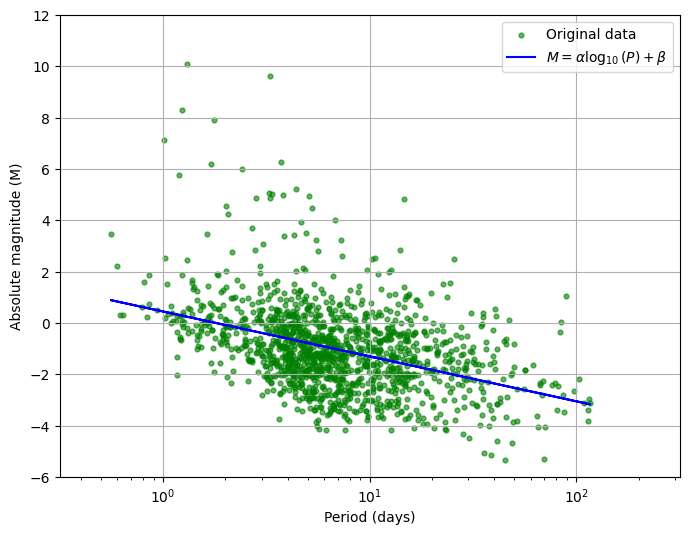

In [34]:
m_vals = gaia_data['mean apparent magnitude'].values
P_vals = gaia_data['time period'].values
plx_vals = gaia_data['parallax'].values

M_vals = [0]*len(m_vals)  # Absolute magnitude
d_vals = [0]*len(plx_vals)  # distance of the cepheids
d_vals = (4.84814e-6*180*(3600/np.pi))/(1e-3*plx_vals)  # in parsecs

M_vals = m_vals - 5*np.log10(d_vals/10)  # M = m-5*log_10(d/10)
P_log_vals = np.log10(P_vals)
coeffs = np.polyfit(P_log_vals, M_vals, deg=1)

alpha = coeffs[0]
beta = coeffs[1]

print("Alpha:", round(alpha,6))
print("Beta:", round(beta,6))

curve_fit = alpha*P_log_vals + beta

plt.figure(figsize=(8, 6))
plt.scatter(10**P_log_vals, M_vals, label='Original data', s=12, c='g', alpha=0.6)
plt.plot(10**P_log_vals, curve_fit, color='blue', label=r'$M = \alpha \log_{10}(P) + \beta$')
plt.xscale('log')
plt.xlabel('Period (days)')
plt.ylabel('Absolute magnitude (M)')
plt.ylim(-6, 12)
plt.xlim(10**-0.5,10**2.5)
plt.grid(True)
plt.legend()
plt.show()

***
### Some useful information about the Magnitude system

The brightness of a star as seen by some observer is dependent on the observer's distance from the star as well as the intrinsic brightness of the star (ignoring any absorption in the intervening space).

In astronomy, brightness of a star, as seen by some observer, is measured in terms of its **apparent magnitude ($m$)**. For two stars (1 and 2) with fluxes $f_1$ and $f_2$ respectively, their apparent magnitudes $m_1$ and $m_2$ are related by:

$m_1 - m_2 = 2.5 \log_{10} \left( \frac{f_1}{f_2} \right)$

**Absolute magnitude ($M$)** of any star is its apparent magnitude if the star was exactly 10 parsecs away from the observer. Thus, $M$ only depends on the intrinsic brightness of the star.

***


# Section 3: Getting the distances to our galaxies

Now that we have our period-luminosity relation, we can observe cepheids in the galaxies in our cluster and use this to get the distances to our galaxies. (Yes, this is possible! Hubble Telescope actually observed Cepheids in the galaxies in Virgo Cluster)


For this, you have been given the data file 'cepheid.csv' which contains the following data fields:
*   Unique ID of the Cepheid
*   Name of the Galaxy to which it belongs
*   Mean Apparent Magnitude ($m$)
*   Time Period of Pulsation (in days)

In [35]:
cepheid_data = pd.read_csv('data/cepheid.csv')

Use the Period-Luminosity Law derived in Section-2 and the above data to find an estimate for the distance to each galaxy in the cluster.

Make sure to handle outliers in the above data. The data may contain some cepheids that actually DO NOT belong to the given galaxy, but it just seems to us that this is the case since they fall along the same line of sight.
***

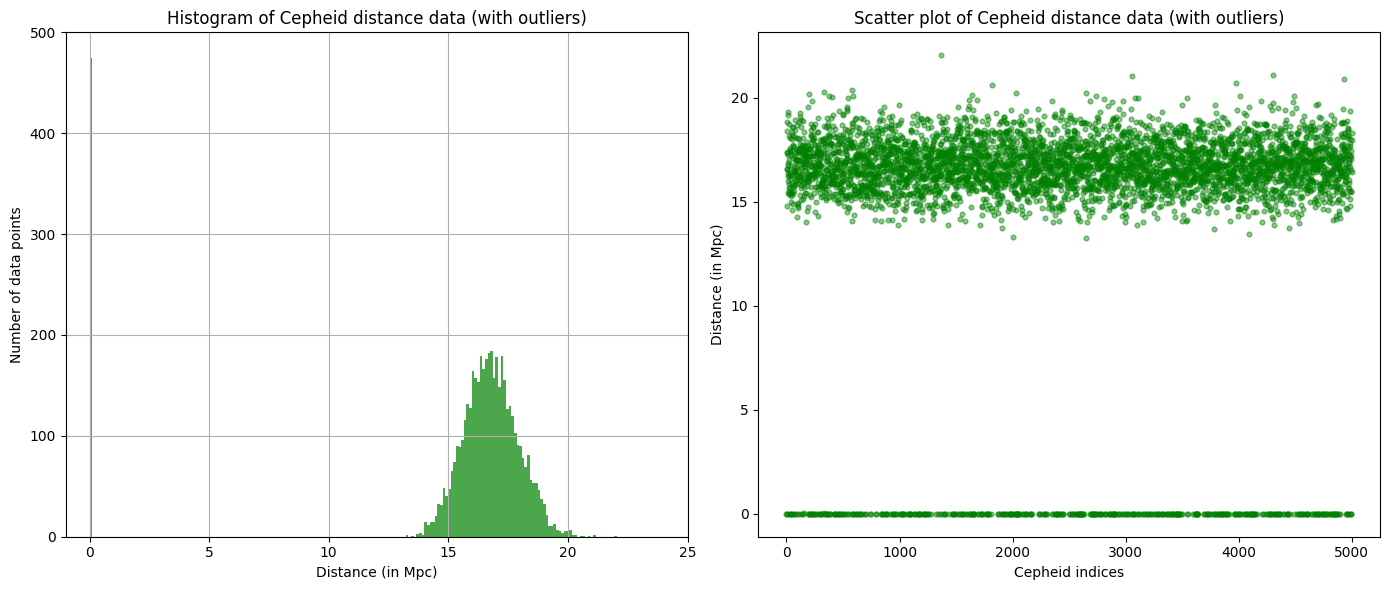

In [36]:
P_vals = cepheid_data['Period'].values
m_vals = cepheid_data['Apparent Magnitude'].values
M_vals = alpha*np.log10(P_vals) + beta  # Absolute magnitude based on Leavitt's Law
d_vals = 10*np.power(10, 0.2*(m_vals-M_vals))/1e6  # Distance in Mpc, from d = 10*10^((m-M)/5)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Histogram plotting
ax1.hist(d_vals, bins=200, density=False, alpha=0.7, color='g')
ax1.set_xlabel('Distance (in Mpc)')
ax1.set_ylabel('Number of data points')
ax1.set_title('Histogram of Cepheid distance data (with outliers)')
ax1.set_ylim(0,500)
ax1.set_xlim(-1,25)
ax1.grid(True)

# Scatter plot
indices = np.arange(len(d_vals))
ax2.scatter(indices, d_vals, s=12, c='g', alpha=0.45)
ax2.set_xlabel('Cepheid indices')
ax2.set_ylabel('Distance (in Mpc)')
ax2.set_title('Scatter plot of Cepheid distance data (with outliers)')

plt.tight_layout()
plt.show()

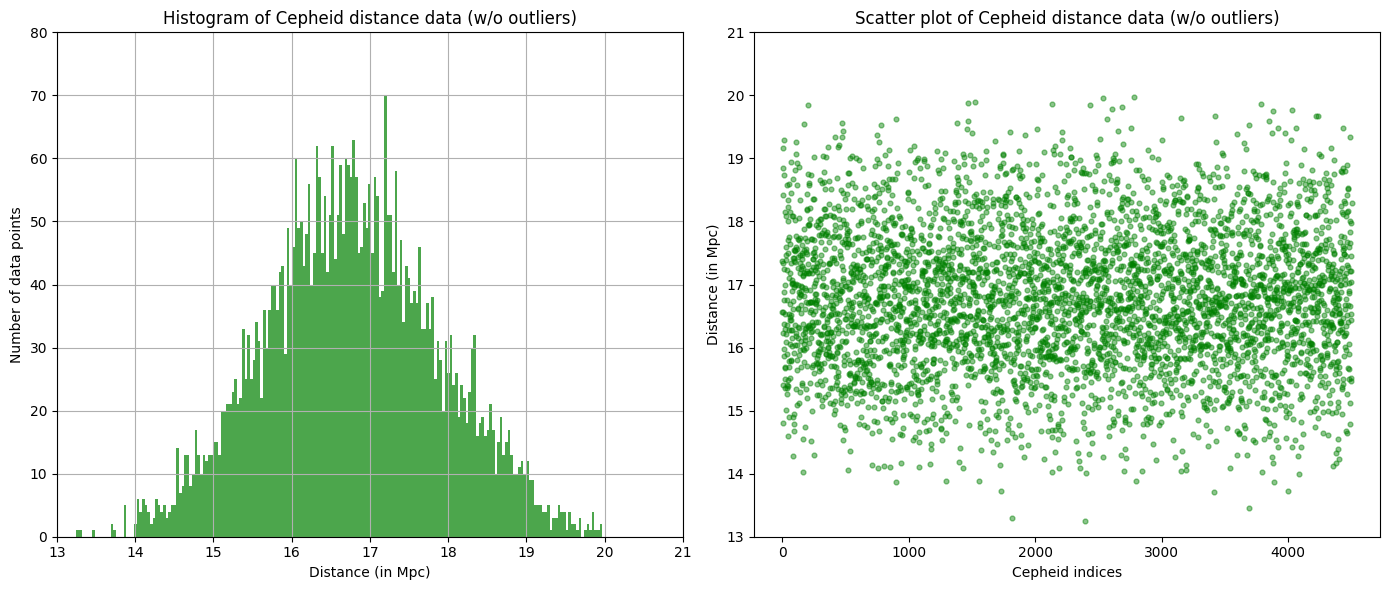

In [37]:
Q1 = np.percentile(d_vals, 25)  # calculate quartiles (25%ile and 75%ile)
Q3 = np.percentile(d_vals, 75)
IQR = Q3 - Q1                   # spread of the middle 50% of data
lower_bound = Q1 - 1.5*IQR      # bounds for the outliers
upper_bound = Q3 + 1.5*IQR

outliers = (d_vals < lower_bound) | (d_vals > upper_bound)  # define the outliers
d_vals = d_vals[~outliers]      # remove outliers from the lists
m_vals = m_vals[~outliers]

# An easier approach would be to eliminate the outliers from a simple visual
# check of the above graph, but this 'precise' method also holds in a general case

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Histogram plotting
ax1.hist(d_vals, bins=200, density=False, alpha=0.7, color='g')
ax1.set_xlabel('Distance (in Mpc)')
ax1.set_ylabel('Number of data points')
ax1.set_title('Histogram of Cepheid distance data (w/o outliers)')
ax1.set_ylim(0,80)
ax1.set_xlim(13,21)
ax1.grid(True)

# Scatter plot
indices = np.arange(len(d_vals))
ax2.scatter(indices, d_vals, s=12, c='g', alpha=0.45)
ax2.set_xlabel('Cepheid indices')
ax2.set_ylabel('Distance (in Mpc)')
ax2.set_title('Scatter plot of Cepheid distance data (w/o outliers)')
ax2.set_ylim(13,21)

plt.tight_layout()
plt.show()

# Section 4: Getting the Hubble's Constant

The famous [Hubble's Law](https://en.wikipedia.org/wiki/Hubble%27s_law) is the observation that galaxies are moving away from Earth at speeds proportional to their distance.

$v = H_0 d$

where $H_0$ is the proportionalaity constant, also known as the Hubble's Constant.

Now that we have an estimate for the radial velocities and distance to the galaxies in our cluster, we need to find an estimate of the Hubble Constant (H).

Fit gaussians on your velocity and distance data and report the mean and standard deviation of the same. Also plot the histograms and the fitted gaussian.

Mean: 16.771554 Mpc
Standard deviation: 1.110831 Mpc


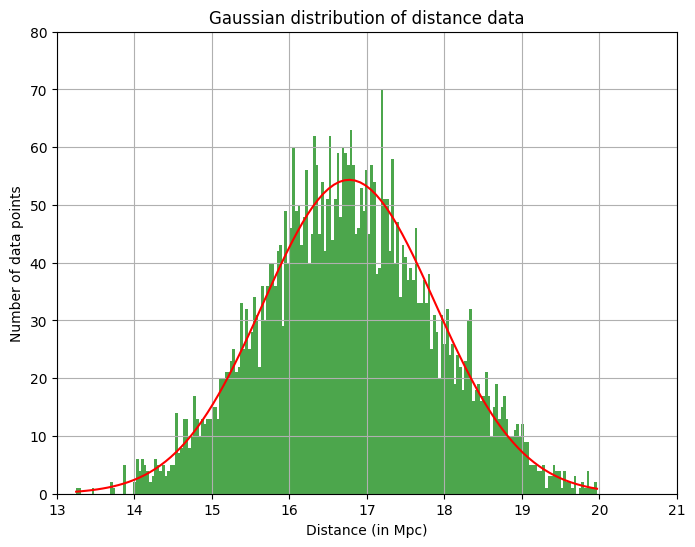

In [38]:
D_mean = np.mean(d_vals)
D_sigma = np.std(d_vals)

print("Mean:", round(D_mean,6), "Mpc")
print("Standard deviation:", round(D_sigma,6), "Mpc")

dist = norm(loc=D_mean, scale=D_sigma)  # Gaussian distribution with mean D_mean and standard deviation D_sigma

plt.figure(figsize=(8,6))
hist, bins, _ = plt.hist(d_vals, bins=200, density=False, alpha=0.7, color='g')  # Plotting the number of data points instead os prob density
bin_width = bins[1] - bins[0]  # width of each histogram bin

x = np.linspace(np.min(d_vals), np.max(d_vals), 100)
gaussian_scaled = dist.pdf(x) * len(d_vals) * bin_width

plt.plot(x, gaussian_scaled, 'r-')
plt.xlabel('Distance (in Mpc)')
plt.ylabel('Number of data points')
plt.title('Gaussian distribution of distance data')
plt.ylim(0,80)
plt.xlim(13,21)
plt.grid(True)
plt.show()

Mean: 0.003188 c
Standard deviation: 0.001859 c


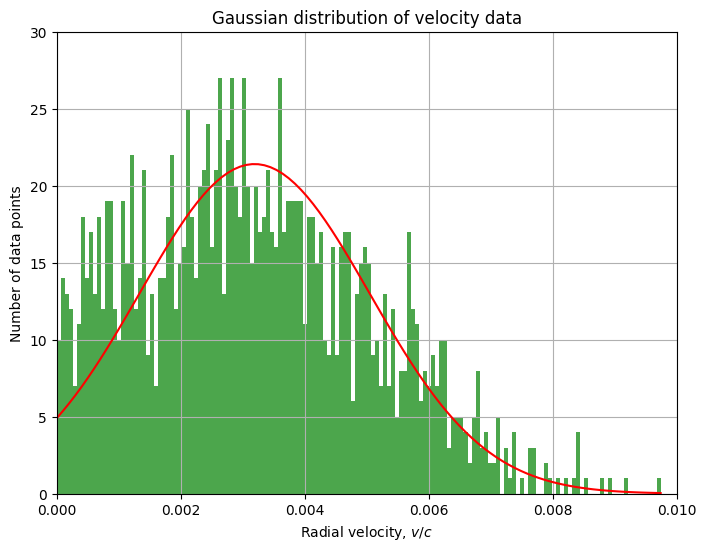

In [39]:
v_mean = np.mean(radial_vel)
v_sigma = np.std(radial_vel)

print("Mean:", round(v_mean,6), "c")
print("Standard deviation:", round(v_sigma,6), "c")

dist = norm(loc=v_mean, scale=v_sigma)  # Gaussian distribution with mean v_mean and standard deviation v_sigma

plt.figure(figsize=(8,6))
hist, bins, _ = plt.hist(radial_vel, bins=150, density=False, alpha=0.7, color='g')  # Plotting the number of data points instead os prob density
bin_width = bins[1] - bins[0]  # width of each histogram bin

x = np.linspace(np.min(radial_vel), np.max(radial_vel), 100)
gaussian_scaled = dist.pdf(x) * len(radial_vel) * bin_width

plt.plot(x, gaussian_scaled, 'r-')
plt.xlabel('Radial velocity, 'r'$v/c$')
plt.ylabel('Number of data points')
plt.title('Gaussian distribution of velocity data')
plt.ylim(0,30)
plt.xlim(0,0.01)
plt.grid(True)
plt.show()

Using the values obtained in the previous part, report your value of $H$ along with the error margins.

In [40]:
H_min = (v_mean-v_sigma)*c*1e-3/(D_mean+D_sigma)  # min possible value of H = (<v>-v_sigma)/(<D>+D_sigma)
H_max = (v_mean+v_sigma)*c*1e-3/(D_mean-D_sigma)  # max possible value of H = (<v>+v_sigma)/(<D>-D_sigma)
H_mean = (H_min+H_max)*0.5                        # mean estimated value of H
print("Estimated range of Hubble's constant:", round(H_min,3), "km/s/Mpc < H <", round(H_max,3), "km/s/Mpc")
print("Mean estimated value of Hubble's constant:", round(H_mean,3), "km/s/Mpc")

Estimated range of Hubble's constant: 22.296 km/s/Mpc < H < 96.683 km/s/Mpc
Mean estimated value of Hubble's constant: 59.49 km/s/Mpc


***

#### Q4.1 Compare the value of $H$ that you got from the standard $H_0$ commonly accepted today. The estimate that you got - is it the same (within error margins), higher or lower than the value of $H_0$.

\< The standard value of $H_0$ is 70 km/s/Mpc, while the estimated value of $H$ from our calculations is around 59.49 km/s/Mpc, with an acceptable range of error ($\approx \pm$ 36 km/s/Mpc), since it's within the same order of magnitude as $H_0$. \>

***

#### Q4.2 What might be the reason behind this difference in values

\< The location of the Cepheids might not be exactly at the center of the galaxies, which would create a small discrepancy in the estimated distance of the galaxy while using the Cepheids as a reference. This *might* be a possible source of error in the estimated value of $H$. \>

***

# Section 5 : Dark Matter

Dark matter is a component of the universe whose presence is discerned from its gravitational attraction rather than its luminosity.

***

#### Q5.1 ESTIMATE the total mass of the Galaxy Cluster. This includes mass due to visible matter as well as dark matter.

HINT: The [Virial Theorem](https://phys.libretexts.org/Bookshelves/Classical_Mechanics/Variational_Principles_in_Classical_Mechanics_%28Cline%29/02%3A_Review_of_Newtonian_Mechanics/2.11%3A_Virial_Theorem) provides a general equation that relates the average over time of the total kinetic energy of a stable system of discrete particles, bound by a conservative force
 $$ \left<KE\right> = -\frac{1}{2} \left<PE\right> $$

\< $6.209 \times 10^{13} \hspace{0.25em} M_{\odot}$  \>


Let us start by proposing an *ansätz* about the density of the cluster: $\rho(r) = \rho_{0}r^{-n}$, where $n \in \mathcal{R}$

The kinetic energy associated with a spherical shell of infinitesimal thickness $dr$ is given by-

$$dK = dm \hspace{0.25em} v^{2} = \rho(r) 4\pi r^{2} \hspace{0.25em} dr \hspace{0.25em} H^{2} r^{2}$$ \\
$$\implies \left<K\right> = \int_{0}^{R} 4\pi \rho(r) H^{2} r^{4} dr = \int_{0}^{R} 4\pi \rho_{0} H^{2} r^{4-n} dr $$ \\
$$\left<K\right> = 4\pi \rho_{0} H^{2} \frac{R^{5-n}}{5-n}$$ \\

Similarly, the potential energy associated with the spherical shell is given by-

$$dU = -\frac{G m(r)}{r} dm = -\frac{G \int_{0}^{r} 4\pi {r^{'}}^{2} dr^{'}}{r} \rho(r) 4\pi r^{2} \hspace{0.25em} dr$$ \\
$$\implies \left<U\right> = -\int_{0}^{R} \frac{G \int_{0}^{r} 4\pi {r^{'}}^{2} dr^{'}}{r} \rho(r) 4\pi r^{2} \hspace{0.25em} dr = -16\pi^{2}G \int_{0}^{R} \int_{0}^{r}\rho(r)\rho(r^{'}){r^{'}}^{2}r \hspace{0.25em} dr^{'} dr$$ \\
$$\implies \left<U\right> = -16\pi^{2}G \int_{0}^{R} \int_{0}^{r} \rho_{0}^{2} {r^{'}}^{2-n} r^{1-n} \hspace{0.25em} dr^{'} dr = -16\pi^{2}G\rho_{0}^{2} \int_{0}^{R} \frac{r^{3-n}}{3-n}r^{1-n} \hspace{0.25em} dr$$ \\
$$ \left<U\right> = -16\pi^{2}G\rho_{0}^{2} \frac{R^{5-2n}}{5-2n}$$ \\

Applying the Virial Theorem, we get
$$ 4\pi \rho_{0} H^{2} \frac{R^{5-n}}{5-n} = 8\pi^{2}G\rho_{0}^{2} \frac{R^{5-2n}}{5-2n} $$ \\
$$ \implies \rho_{0} = \frac{5-2n}{5-n} \frac{H^2}{2\pi G}R^{n} $$ \\
Since $\rho_{0}$ is taken to be a constant as per the inital *ansätz*, $n=0$ for it to be independent of the radial distance. \\
$$ \rho = \rho_{0} = \frac{H^2}{2\pi G}$$ \\

The total mass of the galaxy can be estimated to be- \\
$$ M = \rho_{0}\frac{4\pi R^{3}}{3} = \frac{2H^{2}R^{3}}{G} $$

In [41]:
R = (max(d_vals)-min(d_vals))*0.5*3.086e+22  # SI units
H = H_mean*1e3/3.086e+22
G = 6.6743e-11
M_estimate = 2*(H**2)*(R**3)/G/2e+30
print("Mass of the galaxy cluster:", "{:.3e}".format(M_estimate), "Solar Mass")

Mass of the galaxy cluster: 6.209e+13 Solar Mass



***

#### Q5.2 ESTIMATE the visible mass in the galaxy cluster. Use the Mass - Luminosity Relation for Main-Sequence Stars, assuming that it holds well for galaxies too. You may use the Milky Way as a reference.

Absolute Magnitude of Milky Way $ \approx -21$

Visible mass of Milky Way $\approx 2 \times 10 ^ {11} M_{sun}$

\<$4.782 \times 10^{12}M_{\odot}$\>

In [42]:
M_0 = 2e+11
M_abs = -21
a = 3.5

M_abs_vals = m_vals - 5*np.log10(d_vals*1e6/10)  # absolute magnitude of galaxies
M_vals = M_0*(np.power(10,-0.4*(M_abs_vals-M_abs)))**(1/a)  # mass of galaxies from M-L relation: L \propto M^a, and L = 10^(-0.4*M_abs)
M_visible = sum(M_vals)

print("Visible mass in the galaxy cluster:", "{:.3e}".format(sum(M_vals)), "Solar Mass")

Visible mass in the galaxy cluster: 4.782e+12 Solar Mass


***

#### Q5.3 What is the fraction of the total mass of the galaxy cluster that is actually in the form of Dark Matter

\< 0.923 \>

***

In [43]:
frac = (M_estimate-M_visible)/M_estimate
print("Fraction of Dark Matter in the galaxy cluster:", round(frac,3))

Fraction of Dark Matter in the galaxy cluster: 0.923
